In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)

<IPython.core.display.Javascript object>

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [3]:
#add back the description of the proteins
desc_dict = {}
path = '../TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [4]:
#get glycosome data
ref_df = pd.read_csv('../out_data/glycosome_experiment_extended.txt',sep='\t')    
ref_df['[Ortholog Group]']=ref_df['[Ortholog Group]'].astype('category')
ref_df['ortho_codes']=ref_df['[Ortholog Group]'].cat.codes
ref_df['[Input ID]']=[n.replace(' ','') for n in ref_df['[Input ID]']]
ref_df.set_index('[Input ID]',inplace=True)  
#print (ref_df.head())

lucia_experiments = pd.read_table('../out_data/glycosome_experiment.txt',sep='\t')
lucia_experiments['[Input ID]']=lucia_experiments['GeneDB IDs']
lucia_experiments['[Input ID]']=[n.replace(' ','') for n in lucia_experiments['[Input ID]']]
lucia_experiments.set_index('[Input ID]',inplace=True)
#print (lucia_experiments.head())


ref_df = ref_df.join(lucia_experiments,how='left')
ref_df.drop_duplicates(subset=['[Gene ID]'],inplace=True)
ref_df.set_index('[Gene ID]',inplace=True,drop=True)
ref_df=ref_df[['Log2 H/L','Log10 (Int H*L)','Group', 'Glycosome status ']]
ref_df.head()

,Log2 H/L,Log10 (Int H*L),Group,Glycosome status
[Gene ID],,,,
Tb06.3A7.270,-0.113504,11.743189,i,red
Tb927.9.1350,0.020373,13.847976,i,red
Tb927.9.1360,0.034075,11.430029,i,red
Tb927.9.1380,0.158678,12.763610,i,red
Tb927.9.1410,0.002214,13.992089,i,red


In [5]:
df = pd.read_csv('proteinGroups.txt',sep='\t')
df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)
df=df.join(ref_df,how='left')


tm = pd.read_csv('../GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)


df = df.join(tm, how='left')
df['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df['[SignalP Peptide]'] ] 

removed  40 Only identified by site
tot  40  entries removed
---------------
removed  3 Reverse
tot  43  entries removed
---------------
removed  20 Potential contaminant
tot  63  entries removed
---------------


In [6]:
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Group,Glycosome status,[Gene ID],[source_id],[Genomic Location (Gene)],[Product Description],[# TM Domains],[SignalP Peptide],[SignalP Scores],Unnamed: 8
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb07.11L3.100,Tb07.11L3.100:mRNA-p1;Tb927.7.2150:mRNA-p1,Tb07.11L3.100:mRNA-p1;Tb927.7.2150:mRNA-p1,1;1,1;1,1;1,Tb07.11L3.100:mRNA-p1 | transcript=Tb07.11L3.1...,2,1,1,1,...,NaN,NaN,Tb07.11L3.100,Tb07.11L3.100:mRNA,"11L3_v3:30,224..48,500(-)","hypothetical protein, conserved",0,0,NaN,NaN
Tb927.10.4310,Tb927.10.4310:mRNA-p1;Tb10.v4.0045:mRNA-p1,Tb927.10.4310:mRNA-p1;Tb10.v4.0045:mRNA-p1,2;2,2;2,2;2,Tb927.10.4310:mRNA-p1 | transcript=Tb927.10.43...,2,2,2,2,...,i,red,Tb927.10.4310,Tb927.10.4310:mRNA,"Tb927_10_v5.1:1,121,038..1,122,325(+)","prohibitin 2, putative",1,0,NaN,NaN
Tb927.10.6950,Tb927.10.6950:mRNA-p1;Tb927.10.6910:mRNA-p1;Tb...,Tb927.10.6950:mRNA-p1;Tb927.10.6910:mRNA-p1;Tb...,5;5;5;5,5;5;5;5,5;5;5;5,Tb927.10.6950:mRNA-p1 | transcript=Tb927.10.69...,4,5,5,5,...,NaN,NaN,Tb927.10.6950,Tb927.10.6950:mRNA,"Tb927_10_v5.1:1,752,479..1,754,889(+)","sterol 24-c-methyltransferase, putative",0,0,NaN,NaN
Tb927.11.13007,Tb927.11.13007:mRNA-p1;Tb927.11.13003:mRNA-p1;...,Tb927.11.13007:mRNA-p1;Tb927.11.13003:mRNA-p1;...,1;1;1;1;1,1;1;1;1;1,1;1;1;1;1,Tb927.11.13007:mRNA-p1 | transcript=Tb927.11.1...,5,1,1,1,...,NaN,NaN,Tb927.11.13007,Tb927.11.13007:mRNA,"Tb927_11_v5.1:3,483,084..3,483,582(-)",ubiquitin-60S ribosomal protein L40,0,0,NaN,NaN
Tb11.0400,Tb11.0400:mRNA-p1;Tb927.11.7700.1-p1;Tb11.0300...,Tb11.0400:mRNA-p1;Tb927.11.7700.1-p1;Tb11.0300...,5;4;4,5;4;4,5;4;4,Tb11.0400:mRNA-p1 | transcript=Tb11.0400:mRNA ...,3,5,5,5,...,NaN,NaN,Tb11.0400,Tb11.0400:mRNA,"tryp_XI-1036e06.p1k:31,022..32,483(+)","P27 protein, putative",1,0,NaN,NaN


In [7]:
df['fc']= df['Intensity 1']/df['Intensity']
df['fc2']= df['iBAQ 1']/df['iBAQ']
df['log10_score'] = np.log10(df['Score'])
df[['Gene_desc','fc','fc2']].sort_values('fc',ascending=False).head(5)

,Gene_desc,fc,fc2
Gene_id,,,
Tb07.11L3.100,"hypothetical protein, conserved",1.0,1.0
Tb927.10.14550,ATP-dependent RNA helicase HEL67,1.0,1.0
Tb927.7.2700,"NADH-cytochrome b5 reductase, putative",1.0,1.0
Tb927.11.2360,"phenylalanyl-tRNA synthetase (beta subunit), p...",1.0,1.0
Tb927.7.4180,Fatty acid elongase,1.0,1.0


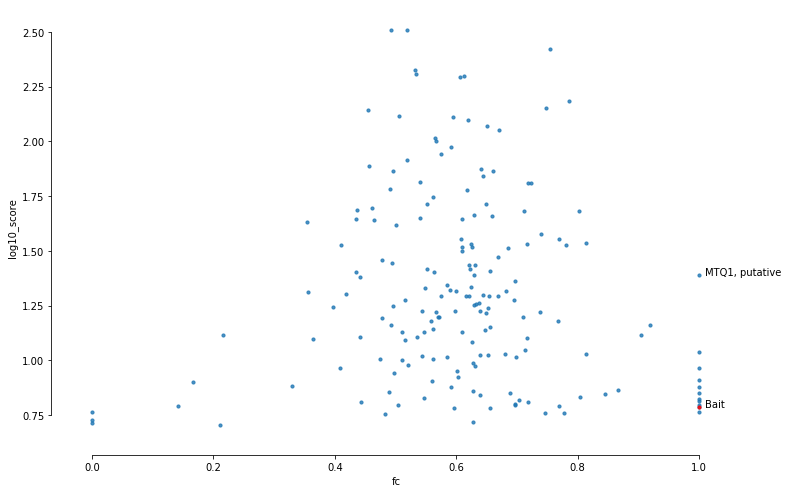

In [19]:
selection = df[df['Score']>5]
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='fc', y='log10_score', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
sns.regplot(x='fc', y='log10_score', 
            fit_reg=False, data = selection.loc[['Tb927.11.12080']],
            ax=ax, scatter_kws={'s':10,'color':'red'})


x = selection.loc[['Tb927.11.12080']]['fc']
y= selection.loc[['Tb927.11.12080']]['log10_score']
ax.annotate('Bait',(x,y),xytext=(x+0.01,y))

x = selection.loc[['Tb927.10.9860']]['fc']
y= selection.loc[['Tb927.10.9860']]['log10_score']
ax.annotate('MTQ1, putative',(x,y),xytext=(x+0.01,y))

plt.show()

In [9]:
#interactive plot

trace_1 = go.Scatter(
    x=selection.fc,
    y=selection.log10_score,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(selection.index.values, selection.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = selection.fc2, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)
'''
annot_1 = go.Scatter(
    x=[selection.fc.loc['Tb927.3.2610']],
    y=[selection.log10_score.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)

annot_1 = go.Scatter(
    x=[selection.fc.loc['Tb927.11.11750']],
    y=[selection.log10_score.loc['Tb927.11.11750']],
    mode='markers+text',
    name='Tb927.11.11750',
    text=['membrane-bound acid phosphatase, putative'],
    textposition='bottom center'
)
'''

layout = dict(title='Crosslinker Experiment')


fig = go.Figure(data=[trace_1], 
                layout=layout)
iplot(fig, filename='test')

In [10]:
def parse_phobius(in_file='../phobius_prediction.txt'):
    res_prot = []
    res_counts = []
    count = 0
    for l in open(in_file):
        if l.startswith('ID'):
            res_prot.append(l.split()[-1].strip())
        if 'TRANSMEM' in l:
            count+=1
        if l.startswith('//'):
            res_counts.append(count)
            count=0
    return res_prot,res_counts
        
res_prot,res_counts=parse_phobius(in_file='../20180820 TbdeAc2 labeel free data-1/phobius_prediction.txt') 
print (len(res_prot),len(res_counts))
tm_count_dict = dict(zip(res_prot,res_counts))
print (tm_count_dict['Tb927.3.2610'])

11567 11567
11


In [11]:
phobius_df = pd.DataFrame()
phobius_df['Gene_ids']=res_prot
phobius_df['TM count']=res_counts
phobius_df.set_index('Gene_ids',inplace=True)

In [12]:
import re
motif_list = [ 'G.S.G', 'G.SGS', 'GDSL', 'GDSA', 'HD..Y', 'Y.G.G', 'HD', 'HE']
motif_list = [re.compile(n) for  n in motif_list]

In [13]:
#add back the description of the proteins
motif_dict = {}
path = '../TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        temp_res = []
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_seq = str(record.seq)
        for item in motif_list:
            temp_res.append(len(item.findall(temp_seq)))
        motif_dict[temp_id]=temp_res        

In [14]:
motif_dict_df = pd.DataFrame(motif_dict).T
motif_dict_df.columns = ['G.S.G', 'G.SGS', 'GDSL', 'GDSA', 'HD..Y', 'Y.G.G', 'HD', 'HE']
motif_dict_df.head()

,G.S.G,G.SGS,GDSL,GDSA,HD..Y,Y.G.G,HD,HE
Tb427.BES40.22,0,0,0,0,0,0,1,1
Tb927.1.05,0,0,0,0,0,0,1,0
Tb927.1.1000,0,0,0,0,0,0,0,0
Tb927.1.100,0,0,0,0,0,0,0,2
Tb927.1.1010,0,0,0,0,0,0,0,0


In [15]:
df=df.join(phobius_df, how='left')

In [16]:
df.to_csv('out.csv')